In [25]:
import argparse
import copy
import glob
import json
import os
import shutil

import scripts.magpietts.evalset_config as evalset_config
import scripts.magpietts.evaluate_generated_audio as evaluate_generated_audio
import numpy as np
import scipy.stats as stats
import soundfile as sf
import torch
from omegaconf.omegaconf import OmegaConf, open_dict
from PIL import Image
import IPython.display as ipd

import matplotlib
%matplotlib inline  
import matplotlib.pyplot as plt

from nemo.collections.asr.parts.utils.manifest_utils import read_manifest
from nemo.collections.tts.data.text_to_speech_dataset import MagpieTTSDataset
from nemo.collections.tts.models import MagpieTTSModel
from nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers import AggregatedTTSTokenizer, IPATokenizer

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Checkpoint Paths

In [2]:
codecmodel_path = "/home/jasoli/models/NanoCodec_21FPS.nemo"
# nemo_file = "/home/jasoli/experiments/nemo_experiments/magpieTTS_en_release_2505/MP_CE_dc_NC21FPS_8cb_lhotseDatasets2505_lr2e-4_tbd700_vbd300_precisionbf16-mixed_0/magpieTTS/checkpoints/magpieTTS.nemo"
nemo_file = "/home/jasoli/experiments/nemo_experiments/magpieTTS_en_release_2505/eos_CausalTextEncoderDecoderAudioContext_audioCodec21fpsCausalDecoder_32_headDim128_lhotseDatasets2505_tbd500_vbd300_tnw6_vnw2_preComputeBinsTemp0.8/magpieTTS.nemo"

def update_config(model_cfg, codecmodel_path, legacy_codebooks=False):
    ''' helper function to rename older yamls from t5 to magpie '''
    model_cfg.codecmodel_path = codecmodel_path
    if hasattr(model_cfg, 'text_tokenizer'):
        # Backward compatibility for models trained with absolute paths in text_tokenizer
        model_cfg.text_tokenizer.g2p.phoneme_dict = "scripts/tts_dataset_files/ipa_cmudict-0.7b_nv23.01.txt"
        model_cfg.text_tokenizer.g2p.heteronyms = "scripts/tts_dataset_files/heteronyms-052722"
        model_cfg.text_tokenizer.g2p.phoneme_probability = 1.0
    model_cfg.train_ds = None
    model_cfg.validation_ds = None
    if "t5_encoder" in model_cfg:
        model_cfg.encoder = model_cfg.t5_encoder
        del model_cfg.t5_encoder
    if "t5_decoder" in model_cfg:
        model_cfg.decoder = model_cfg.t5_decoder
        del model_cfg.t5_decoder
    if hasattr(model_cfg, 'decoder') and hasattr(model_cfg.decoder, 'prior_eps'):
        # Added to prevent crash after removing arg from transformer_2501.py in https://github.com/blisc/NeMo/pull/56
        del model_cfg.decoder.prior_eps
    if legacy_codebooks:
        # Added to address backward compatibility arising from
        #  https://github.com/blisc/NeMo/pull/64
        print("WARNING: Using legacy codebook indices for backward compatibility. Should only be used with old checkpoints.")
        num_audio_tokens_per_codebook = model_cfg.num_audio_tokens_per_codebook
        model_cfg.forced_num_all_tokens_per_codebook = num_audio_tokens_per_codebook
        model_cfg.forced_audio_eos_id = num_audio_tokens_per_codebook - 1
        model_cfg.forced_audio_bos_id = num_audio_tokens_per_codebook - 2
        if model_cfg.model_type == 'decoder_context_tts':
            model_cfg.forced_context_audio_eos_id = num_audio_tokens_per_codebook - 3
            model_cfg.forced_context_audio_bos_id = num_audio_tokens_per_codebook - 4
            model_cfg.forced_mask_token_id = num_audio_tokens_per_codebook - 5
        else:
            model_cfg.forced_context_audio_eos_id = num_audio_tokens_per_codebook - 1
            model_cfg.forced_context_audio_bos_id = num_audio_tokens_per_codebook - 2

    return model_cfg

model_cfg = MagpieTTSModel.restore_from(nemo_file, return_config=True)
with open_dict(model_cfg):
    model_cfg = update_config(model_cfg, codecmodel_path, False)
model = MagpieTTSModel.restore_from(nemo_file, override_config_path=model_cfg)
model.use_kv_cache_for_inference = True
model.cuda()
model.eval()

[NeMo W 2025-06-12 20:29:38 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      dataset_type: tarred_vocoder
      dataset_args:
        dataset_meta:
          mls_english:
            manifest_path: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/mls_english/filtered_22khz/tarred_audio/train_manifest.json
            tar_filepath: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/mls_english/filtered_22khz/tarred_audio/audio_{0..1999}.tar
          cv:
            manifest_path: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/commonvoice13/22khz/tarred_audio/train_manifest.json
            tar_filepath: /lustre/fsw/portfolios/llmservice/projects/llmservice_nemo_speechlm/data/TTS/commonvoice13/22khz/tarred_audio/audio_{0..279}.tar

[NeMo I 2025-06-12 20:29:39 nemo_logging:393] Vector quantizer does not support commit loss.
[NeMo I 2025-06-12 20:29:40 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-12 20:29:40 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-12 20:29:40 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-12 20:29:40 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-12 20:29:40 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-12 20:29:40 nemo_logging:393] PADDING: 1
Speaker encoder loaded and frozen !!
[NeMo I 2025-06-12 20:29:45 nemo_logging:393] Model AudioCodecModel was successfully restored from /home/jasoli/models/NanoCodec_21FPS.nemo.


[NeMo W 2025-06-12 20:29:45 nemo_logging:405] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-06-12 20:29:46 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-06-12 20:29:46 nemo_logging:405] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.


[NeMo I 2025-06-12 20:29:49 nemo_logging:393] Model MagpieTTSModel was successfully restored from /home/jasoli/experiments/nemo_experiments/magpieTTS_en_release_2505/eos_CausalTextEncoderDecoderAudioContext_audioCodec21fpsCausalDecoder_32_headDim128_lhotseDatasets2505_tbd500_vbd300_tnw6_vnw2_preComputeBinsTemp0.8/magpieTTS.nemo.


MagpieTTSModel(
  (_codec_model): AudioCodecModel(
    (audio_encoder): HiFiGANEncoder(
      (pre_conv): Conv1dNorm(
        (conv): ParametrizedConv1d(
          1, 24, kernel_size=(7,), stride=(1,), padding=(3,), padding_mode=replicate
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
      )
      (activations): ModuleList(
        (0-4): 5 x CodecActivation(
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (down_sample_conv_layers): ModuleList(
        (0): Conv1dNorm(
          (conv): ParametrizedConv1d(
            24, 48, kernel_size=(4,), stride=(2,), padding=(1,), padding_mode=replicate
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
        )
        (1): Conv1dNorm(
          (conv): ParametrizedConv1d(
            48, 96, ke

### Initialize Dataset class and helper functions

In [3]:
dataset_meta_info = {
    'manifest_path' : '/home/jasoli/data_prime/manifests/test_clean_jr.json',
    'audio_dir' : '/mnt/drive1/data/LibriTTS/',
    'feature_dir' : None,
}
dataset_meta = {'test': dataset_meta_info}
context_durration_min = model.cfg.get('context_duration_min', 5.0)
context_durration_max = model.cfg.get('context_duration_max', 5.0)
if context_durration_min < 5.0 and context_durration_max > 5.0:
    context_durration_min = 5.0
    context_durration_max = 5.0 # @pneekhara - For multiencoder models, I want fixed size contexts for fair eval. Not too important though.
test_dataset = MagpieTTSDataset(
    dataset_meta=dataset_meta,
    sample_rate=model.sample_rate,
    min_duration=0.5,
    max_duration=20,
    codec_model_samples_per_frame=model.codec_model_samples_per_frame,
    bos_id=model.bos_id,
    eos_id=model.eos_id,
    context_audio_bos_id=model.context_audio_bos_id,
    context_audio_eos_id=model.context_audio_eos_id,
    audio_bos_id=model.audio_bos_id,
    audio_eos_id=model.audio_eos_id,
    num_audio_codebooks=model.num_audio_codebooks,
    prior_scaling_factor=None,
    load_cached_codes_if_available=False,
    dataset_type='test',
    tokenizer_config=None,
    load_16khz_audio=model.model_type == 'single_encoder_sv_tts',
    use_text_conditioning_tokenizer=model.use_text_conditioning_encoder,
    pad_context_text_to_max_duration=model.pad_context_text_to_max_duration,
    context_duration_min=context_durration_min,
    context_duration_max=context_durration_max,
)
test_dataset.text_tokenizer = model.tokenizer
# Set phoneme prob = 1 for g2p
g2p = None
if isinstance(model.tokenizer, AggregatedTTSTokenizer):
    g2p = model.tokenizer.tokenizers["english_phoneme"].g2p
elif isinstance(model.tokenizer, IPATokenizer):
    g2p = model.tokenizer.g2p
if g2p is not None:
    g2p.phoneme_probability = 1.0
test_dataset.text_conditioning_tokenizer = model.text_conditioning_tokenizer

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=4,
    collate_fn=test_dataset.collate_fn,
    num_workers=2,
    shuffle=False
)

for bidx, batch in enumerate(test_data_loader):
    batch_cuda ={}
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch_cuda[key] = batch[key].cuda()
        else:
            batch_cuda[key] = batch[key]
    break

[NeMo I 2025-06-12 20:29:49 nemo_logging:393] test
[NeMo I 2025-06-12 20:29:49 nemo_logging:393] Original # of files: 6
[NeMo I 2025-06-12 20:29:49 nemo_logging:393] Filtered # of files: 6
[NeMo I 2025-06-12 20:29:49 nemo_logging:393] Original duration: 0.01 hours
[NeMo I 2025-06-12 20:29:49 nemo_logging:393] Filtered duration: 0.01 hours


### Set transcript and context pairs to test

Decoding timestep 0
Decoding timestep 20
End detected for item 1 at timestep 35
Decoding timestep 40
End detected for item 2 at timestep 41
End detected for item 0 at timestep 45
Decoding timestep 60
End detected for item 3 at timestep 76
All ends reached


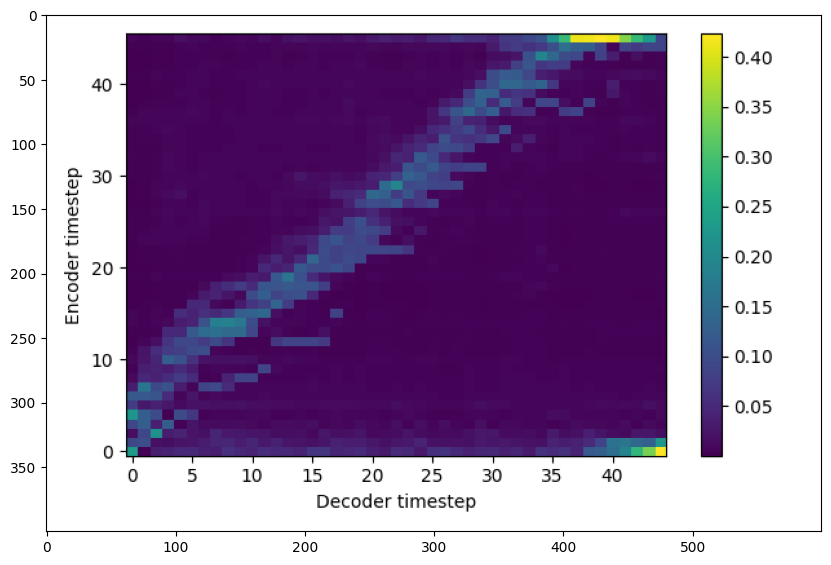

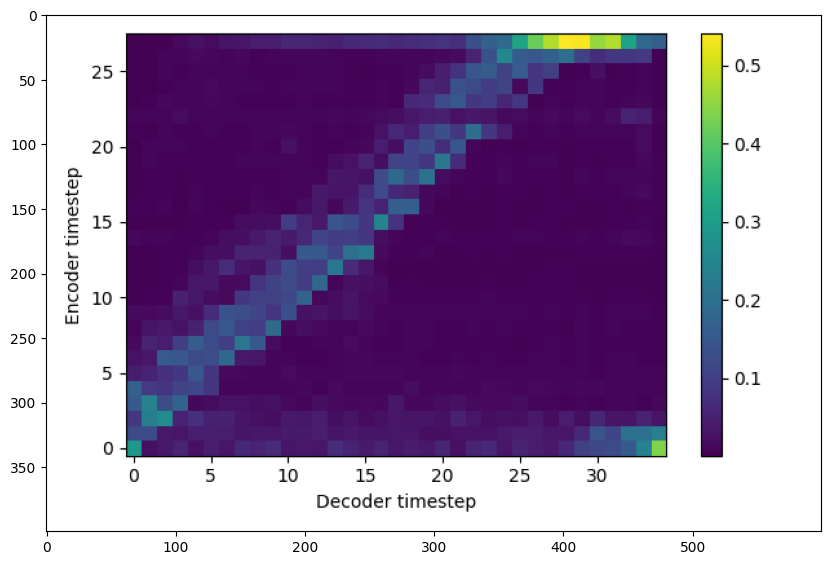

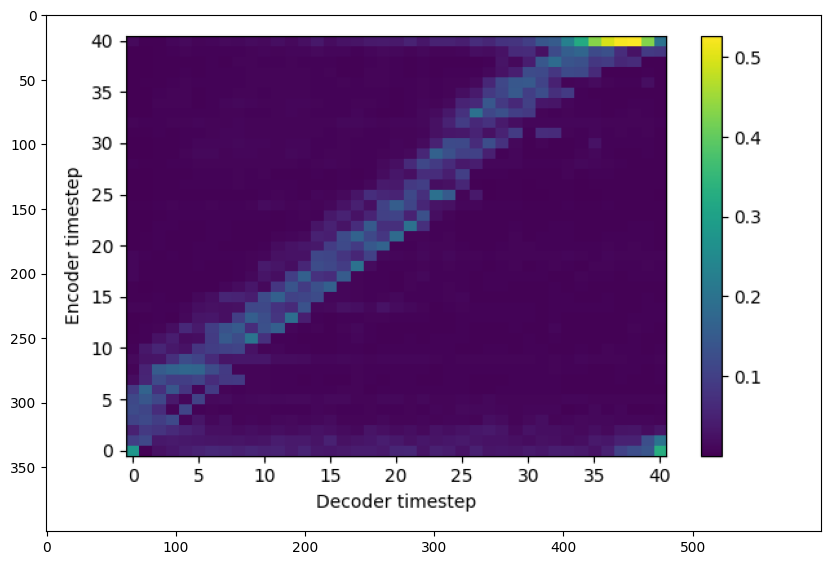

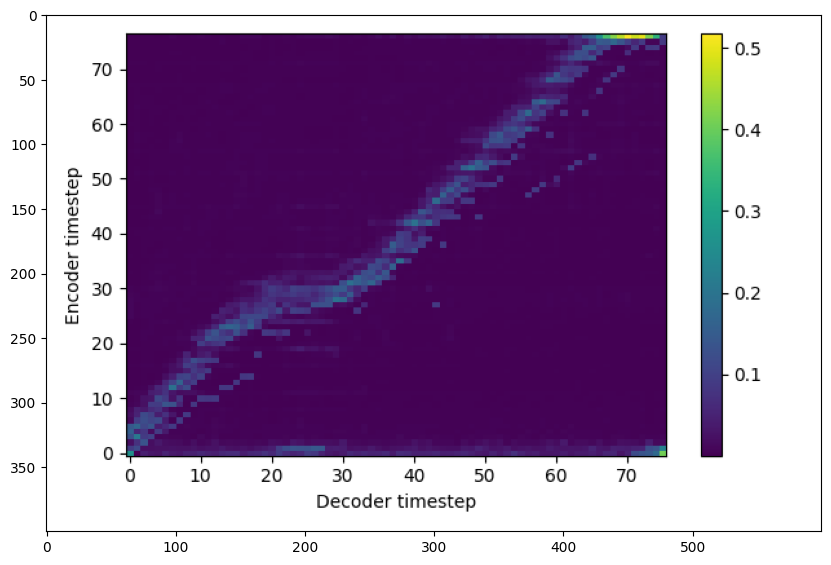

In [21]:
apply_attention_prior = True
def construct_inference_prior(self, prior_epsilon, cross_attention_scores,
                              text_lens, text_time_step_attended, attended_timestep_counter,
                              unfinished_texts, finished_texts_counter, end_indices, batch_size):
    # Attn prior for the next timestep
    _attn_prior = torch.zeros(cross_attention_scores.shape[0], 1, cross_attention_scores.shape[1]) + prior_epsilon
    _attn_prior = _attn_prior.to(cross_attention_scores.device)
    for bidx in range(cross_attention_scores.shape[0]):
        if bidx < batch_size:
            _text_len = text_lens[bidx]
            _attn_prior[bidx, 0, :] = 1.0
            # if text_lens[bidx] <= 5:
            #     # Very short sentences, No Prior
            #     _attn_prior[bidx, 0, :] = 1.0
            # else:
            #     # _attn_prior[bidx, 0, max(1, text_time_step_attended[bidx]-2)] = 0.1 # Slight exposure to history for better pronounciation. Not very important.
            #     _attn_prior[bidx, 0, max(1, text_time_step_attended[bidx]-2)] = 1.
            #     _attn_prior[bidx, 0, max(1, text_time_step_attended[bidx]-1)] = 1.
            #     _attn_prior[bidx, 0, text_time_step_attended[bidx]] = 1.
            #     _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+1, _text_len - 1) ] = 1.0
            #     _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+2, _text_len - 1) ] = 1.
            #     _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+3, _text_len - 1) ] = 1.

            # Penalize timesteps that have been attended to more than 10 times
            for _timestep in attended_timestep_counter[bidx]:
                if attended_timestep_counter[bidx][_timestep] >= 10:
                    # This means the timestep has been attended to more than 10 times (To avoid getting stuck)
                    _attn_prior[bidx, 0, _timestep] = prior_epsilon

            unfinished_texts[bidx] = False
            if text_time_step_attended[bidx] < text_lens[bidx] - 3:
                # This means the sentence has not ended
                if bidx not in end_indices:
                    unfinished_texts[bidx] = True

            if text_time_step_attended[bidx] >= text_lens[bidx] - 5 or bidx in end_indices:
                if bidx not in finished_texts_counter:
                    finished_texts_counter[bidx] = 0

    for bidx in finished_texts_counter:
        finished_texts_counter[bidx] += 1
        if finished_texts_counter[bidx] > 10:
            # This means we have been within the text EOS window for atleast 10 timesteps
            # We should allow EOS to be predicted now.
            unfinished_texts[bidx] = False

    return _attn_prior, unfinished_texts, finished_texts_counter

model.construct_inference_prior = construct_inference_prior.__get__(model, MagpieTTSModel)  # Replacing the method for instance1
model.get_most_attended_text_timestep = get_most_attended_text_timestep.__get__(model, MagpieTTSModel)  # Replacing the method for instance1

predicted_audio, predicted_audio_lens, predicted_codes, predicted_codes_lens, rtf_metrics, cross_attention_maps, headwise_cross_attention_maps  = model.infer_batch(
    batch_cuda,
    max_decoder_steps=440,
    temperature=0.6,
    topk=80,
    use_cfg=True,
    cfg_scale=2.5,
    return_cross_attn_probs=True,
    apply_attention_prior=apply_attention_prior,
    prior_epsilon=0.,
    lookahead_window_size=10,
    estimate_alignment_from_layers=None,
    apply_prior_to_layers=None,
    start_prior_after_n_audio_steps=10,
    use_local_transformer_for_inference=False,
    compute_all_heads_attn_maps=True
)
for idx in range(predicted_audio.size(0)):
    cross_attn_map_image = Image.fromarray(cross_attention_maps[idx])
    # cross_attn_map_image.save(os.path.join(audio_dir, f"cross_attn_map_{item_idx}.png"))

    predicted_audio_np = predicted_audio[idx].float().detach().cpu().numpy()
    predicted_audio_np = predicted_audio_np[:predicted_audio_lens[idx]]
    # audio_path = os.path.join(pred_audio_dir, f"predicted_audio_{item_idx}.wav")
    # sf.write(audio_path, predicted_audio_np, model.sample_rate)
    # codes_path = os.path.join(pred_audio_dir, f"predicted_codes_{item_idx}.pt")
    # torch.save(predicted_codes[idx][:predicted_codes_lens[idx]], codes_path)
    # codec_file_paths.append(codes_path)
    # context_audio_path = manifest_records[item_idx].get('context_audio_filepath', None)
    # target_audio_path = manifest_records[item_idx].get('audio_filepath', None)
    # if context_audio_path is not None:
    #     context_audio_path = os.path.join(dataset_meta_info[dataset]['audio_dir'], context_audio_path)
    # if target_audio_path is not None:
    #     target_audio_path = os.path.join(dataset_meta_info[dataset]['audio_dir'], target_audio_path)
    # if os.path.exists(context_audio_path):
    #     shutil.copy(context_audio_path, os.path.join(audio_dir, f"context_audio_{item_idx}.wav"))
    # if os.path.exists(target_audio_path):
    #     shutil.copy(target_audio_path, os.path.join(audio_dir, f"target_audio_{item_idx}.wav"))
    # item_idx += 1
    fig, ax = plt.subplots(1, figsize=(10, 60))
    ax.imshow(cross_attn_map_image)
    ipd.display(ipd.Audio(predicted_audio_np, rate=model.sample_rate))

### Generate With Prior

Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
End detected for item 0 at timestep 43
End detected for item 2 at timestep 47
End detected for item 1 at timestep 56
Decoding timestep 60
End detected for item 3 at timestep 66
All ends reached


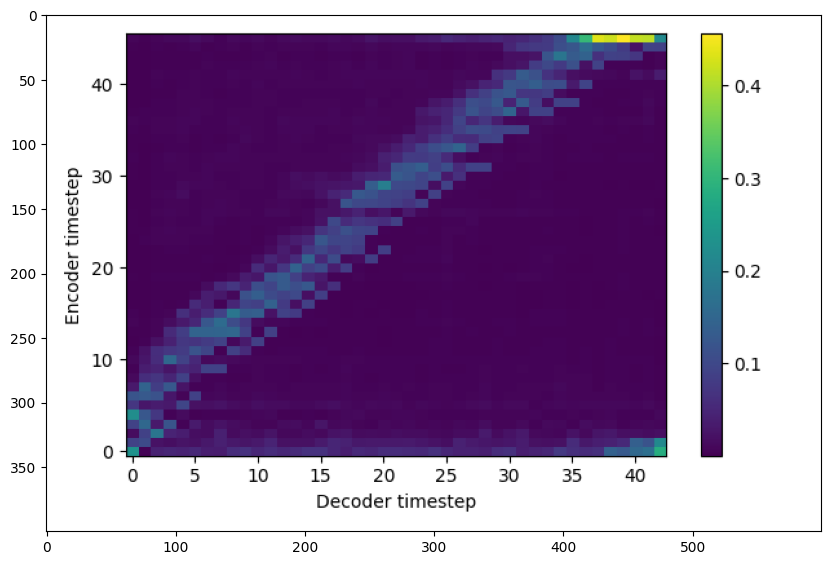

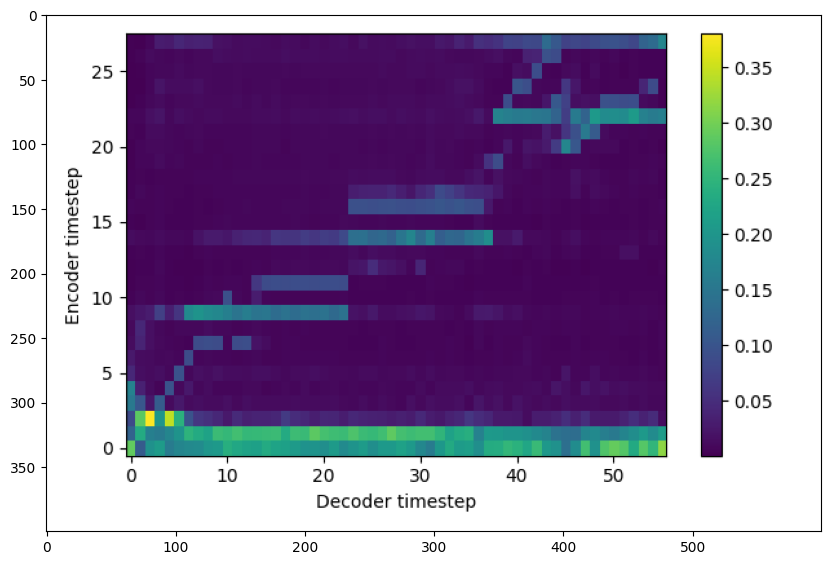

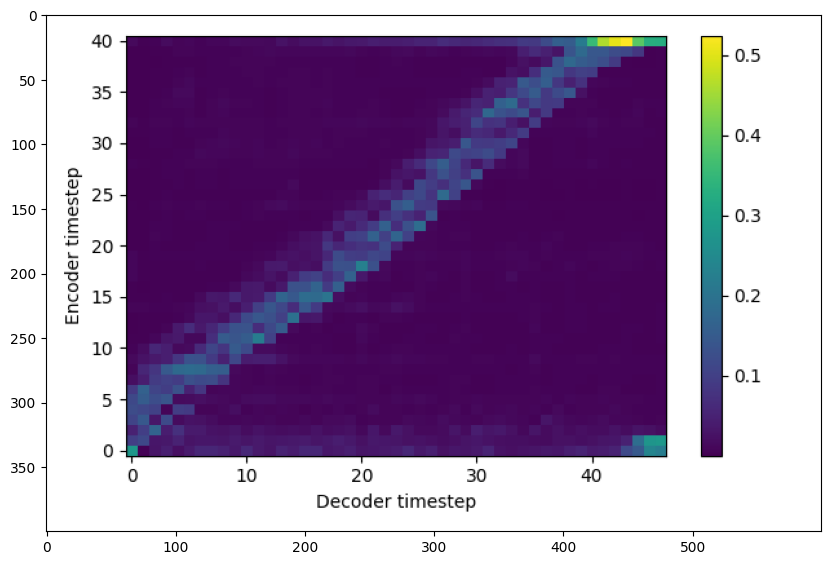

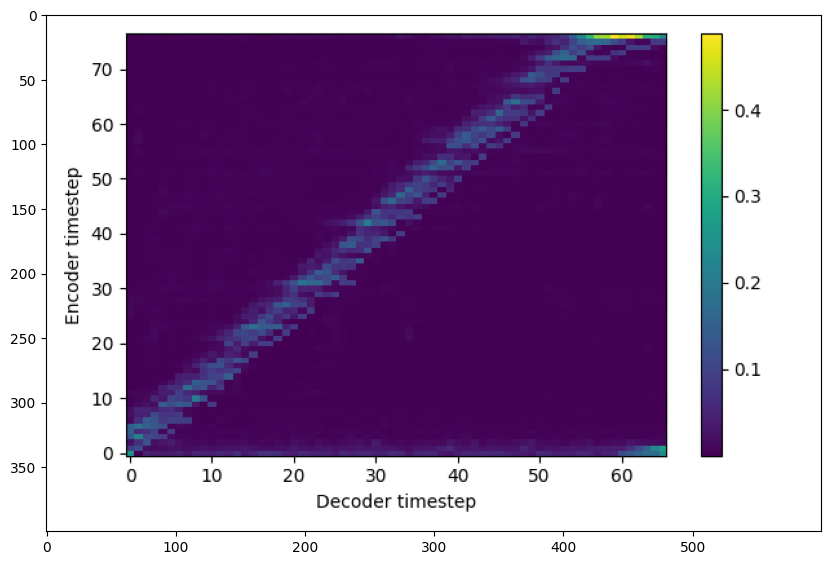

In [33]:
apply_attention_prior = True
def get_most_attended_text_timestep(self, alignment_attention_scores, last_attended_timesteps,
                               text_lens, lookahead_window_size, attended_timestep_counter, batch_size):
    """
    Returns the most attended timestep for each batch item
    """
    text_time_step_attended = []
    for bidx in range(batch_size):
        last_attended_timestep = last_attended_timesteps[-1][bidx]
        if attended_timestep_counter[bidx].get(last_attended_timestep, 0) >= 8:
            # This is probably an attention sink! Move to the next timestep
            last_attended_timestep += 1
        window_size = lookahead_window_size
        window_end = min(last_attended_timestep + window_size, text_lens[bidx] - 3) # Ignore the last 3 timesteps
        item_attention_scores = alignment_attention_scores[bidx,last_attended_timestep:window_end]
        if item_attention_scores.size(0) == 0:
            # This means the sentence has ended
            attended_timestep = text_lens[bidx] - 1
        else:
            attended_timestep = item_attention_scores.argmax().item() + last_attended_timestep
        text_time_step_attended.append(attended_timestep)
        attended_timestep_counter[bidx][attended_timestep] = attended_timestep_counter[bidx].get(attended_timestep, 0) + 1
    return text_time_step_attended, attended_timestep_counter

def construct_inference_prior(self, prior_epsilon, cross_attention_scores,
                              text_lens, text_time_step_attended, attended_timestep_counter,
                              unfinished_texts, finished_texts_counter, end_indices, batch_size):
    # Attn prior for the next timestep
    _attn_prior = torch.zeros(cross_attention_scores.shape[0], 1, cross_attention_scores.shape[1]) + prior_epsilon
    _attn_prior = _attn_prior.to(cross_attention_scores.device)
    for bidx in range(cross_attention_scores.shape[0]):
        if bidx < batch_size:
            _text_len = text_lens[bidx]
            # _attn_prior[bidx, 0, :] = 1.0
            # if text_lens[bidx] <= 5:
            #     # Very short sentences, No Prior
            #     _attn_prior[bidx, 0, :] = 1.0
            # else:
            #     # _attn_prior[bidx, 0, max(1, text_time_step_attended[bidx]-2)] = 0.1 # Slight exposure to history for better pronounciation. Not very important.
            _attn_prior[bidx, 0, max(1, text_time_step_attended[bidx]-2)] = 1.
            _attn_prior[bidx, 0, max(1, text_time_step_attended[bidx]-1)] = 1.
            _attn_prior[bidx, 0, text_time_step_attended[bidx]] = 1.
            _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+1, _text_len - 1) ] = 1.0
            _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+2, _text_len - 1) ] = 1.
            _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+3, _text_len - 1) ] = 1.
            _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+4, _text_len - 1) ] = 1.
            _attn_prior[bidx, 0, min(text_time_step_attended[bidx]+5, _text_len - 1) ] = 1.

            # Penalize timesteps that have been attended to more than 10 times
            for _timestep in attended_timestep_counter[bidx]:
                if attended_timestep_counter[bidx][_timestep] >= 10:
                    # This means the timestep has been attended to more than 10 times (To avoid getting stuck)
                    _attn_prior[bidx, 0, _timestep] = prior_epsilon

            unfinished_texts[bidx] = False
            if text_time_step_attended[bidx] < text_lens[bidx] - 3:
                # This means the sentence has not ended
                if bidx not in end_indices:
                    unfinished_texts[bidx] = True

            if text_time_step_attended[bidx] >= text_lens[bidx] - 5 or bidx in end_indices:
                if bidx not in finished_texts_counter:
                    finished_texts_counter[bidx] = 0

    for bidx in finished_texts_counter:
        finished_texts_counter[bidx] += 1
        if finished_texts_counter[bidx] > 10:
            # This means we have been within the text EOS window for atleast 10 timesteps
            # We should allow EOS to be predicted now.
            unfinished_texts[bidx] = False

    return _attn_prior, unfinished_texts, finished_texts_counter

model.construct_inference_prior = construct_inference_prior.__get__(model, MagpieTTSModel)  # Replacing the method for instance1
model.get_most_attended_text_timestep = get_most_attended_text_timestep.__get__(model, MagpieTTSModel)  # Replacing the method for instance1

predicted_audio, predicted_audio_lens, predicted_codes, predicted_codes_lens, rtf_metrics, cross_attention_maps, headwise_cross_attention_maps  = model.infer_batch(
    batch_cuda,
    max_decoder_steps=440,
    temperature=0.6,
    topk=80,
    use_cfg=True,
    cfg_scale=2.5,
    return_cross_attn_probs=True,
    apply_attention_prior=apply_attention_prior,
    prior_epsilon=0.,
    lookahead_window_size=10,
    apply_prior_to_layers=[4,6,10],
    estimate_alignment_from_layers=[4,6,10],
    start_prior_after_n_audio_steps=3,
    use_local_transformer_for_inference=False,
    compute_all_heads_attn_maps=True
)
for idx in range(predicted_audio.size(0)):
    cross_attn_map_image = Image.fromarray(cross_attention_maps[idx])
    # cross_attn_map_image.save(os.path.join(audio_dir, f"cross_attn_map_{item_idx}.png"))

    predicted_audio_np = predicted_audio[idx].float().detach().cpu().numpy()
    predicted_audio_np = predicted_audio_np[:predicted_audio_lens[idx]]
    # audio_path = os.path.join(pred_audio_dir, f"predicted_audio_{item_idx}.wav")
    # sf.write(audio_path, predicted_audio_np, model.sample_rate)
    # codes_path = os.path.join(pred_audio_dir, f"predicted_codes_{item_idx}.pt")
    # torch.save(predicted_codes[idx][:predicted_codes_lens[idx]], codes_path)
    # codec_file_paths.append(codes_path)
    # context_audio_path = manifest_records[item_idx].get('context_audio_filepath', None)
    # target_audio_path = manifest_records[item_idx].get('audio_filepath', None)
    # if context_audio_path is not None:
    #     context_audio_path = os.path.join(dataset_meta_info[dataset]['audio_dir'], context_audio_path)
    # if target_audio_path is not None:
    #     target_audio_path = os.path.join(dataset_meta_info[dataset]['audio_dir'], target_audio_path)
    # if os.path.exists(context_audio_path):
    #     shutil.copy(context_audio_path, os.path.join(audio_dir, f"context_audio_{item_idx}.wav"))
    # if os.path.exists(target_audio_path):
    #     shutil.copy(target_audio_path, os.path.join(audio_dir, f"target_audio_{item_idx}.wav"))
    # item_idx += 1
    fig, ax = plt.subplots(1, figsize=(10, 60))
    ax.imshow(cross_attn_map_image)
    ipd.display(ipd.Audio(predicted_audio_np, rate=model.sample_rate))

In [18]:
len(headwise_cross_attention_maps[0])

12

0


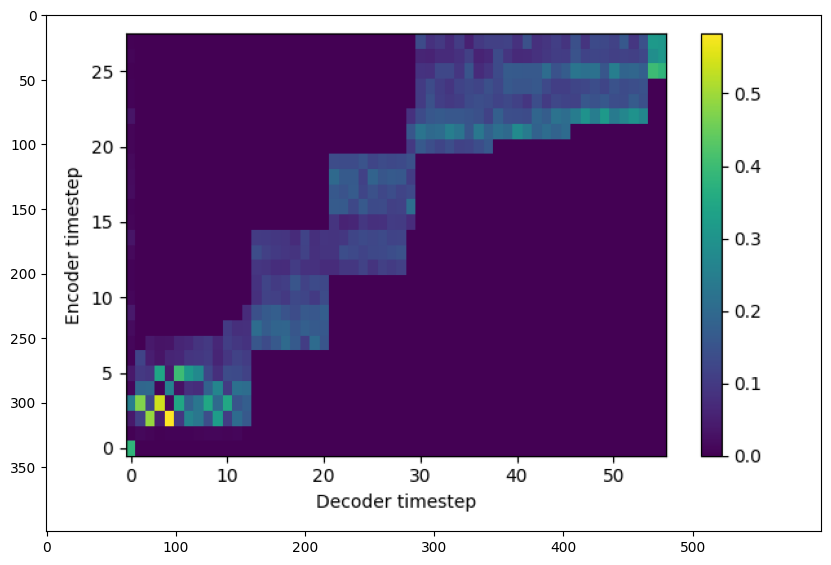

1


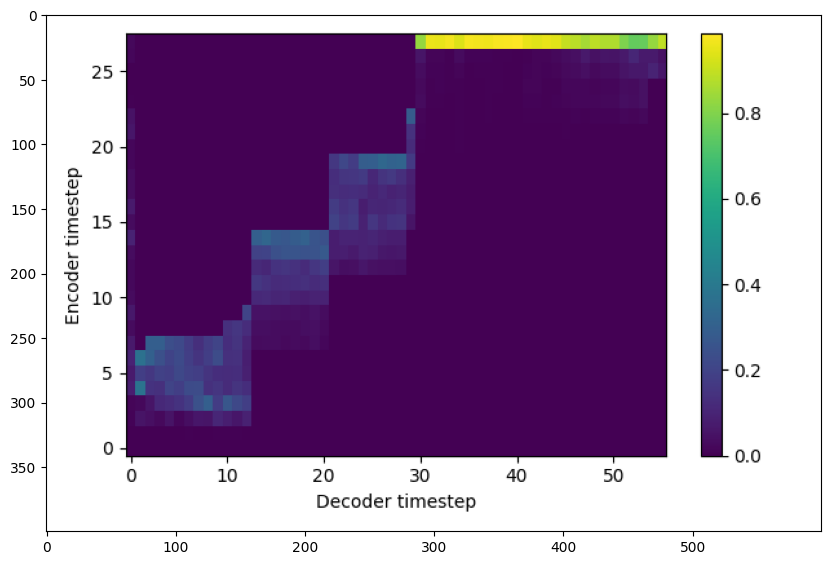

2


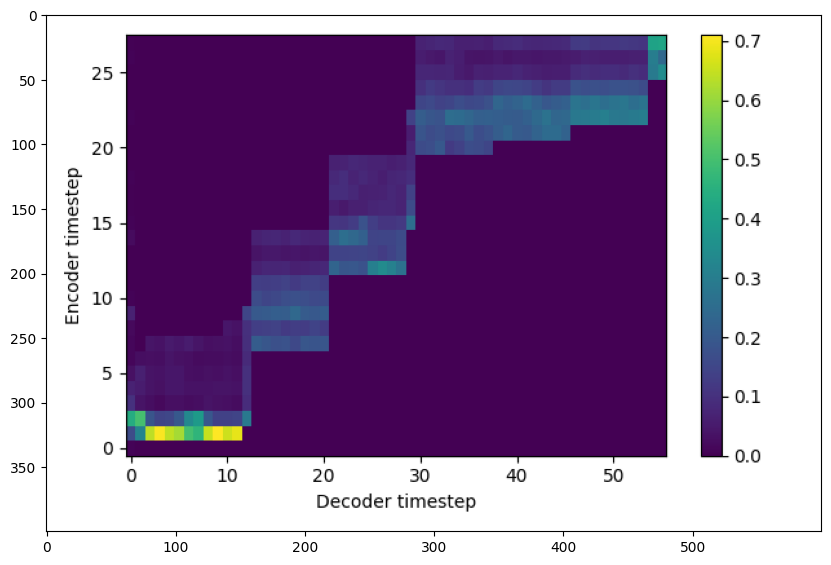

3


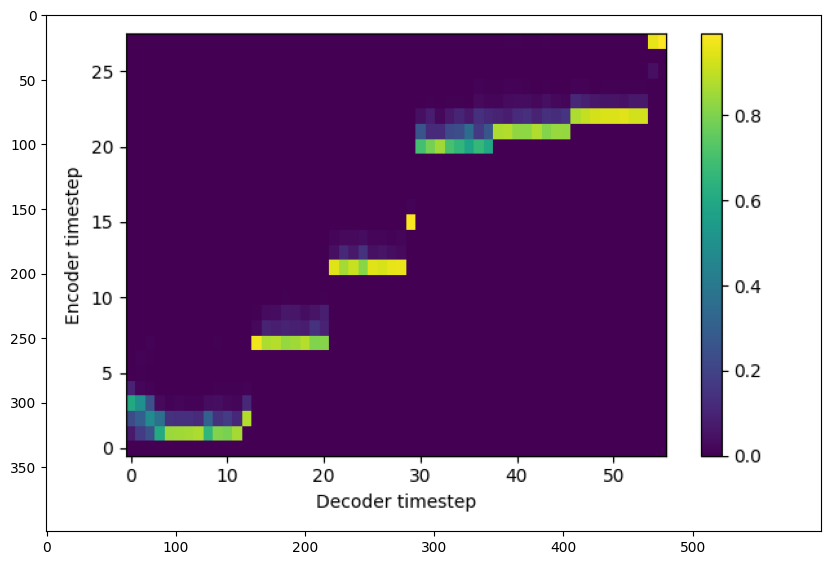

4


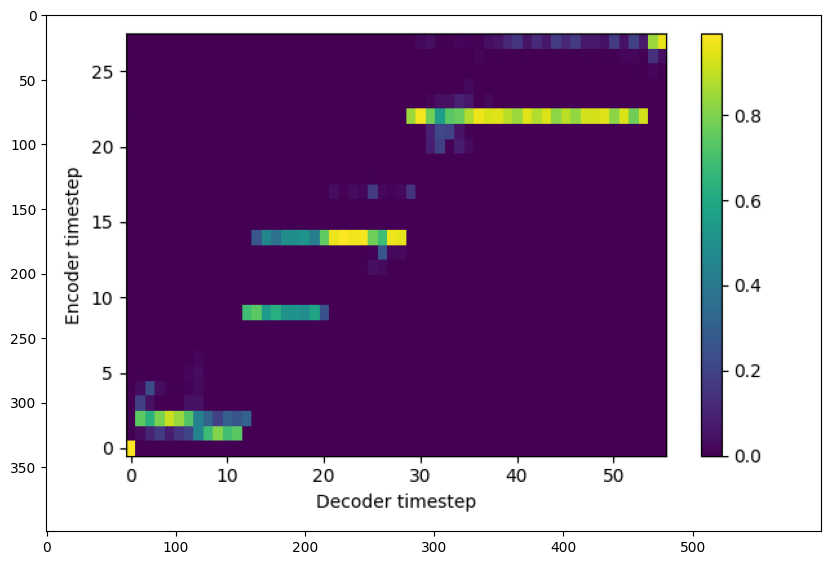

5


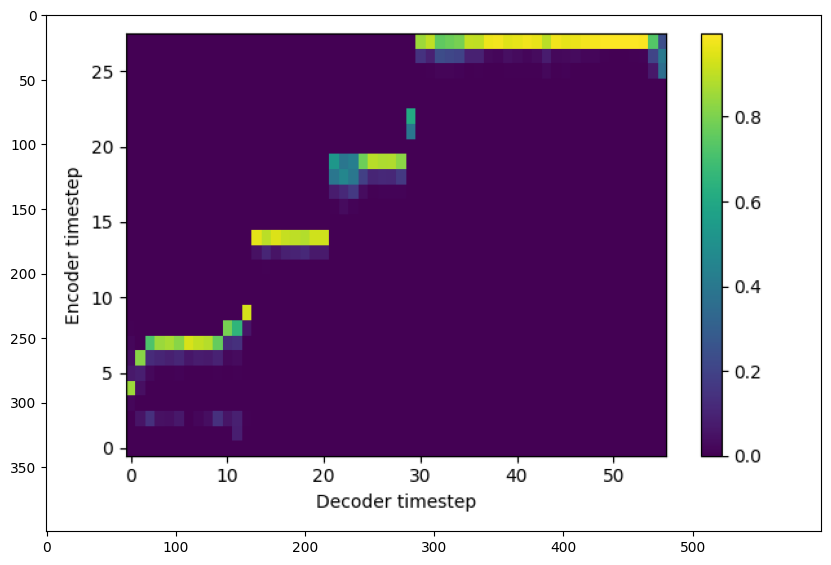

6


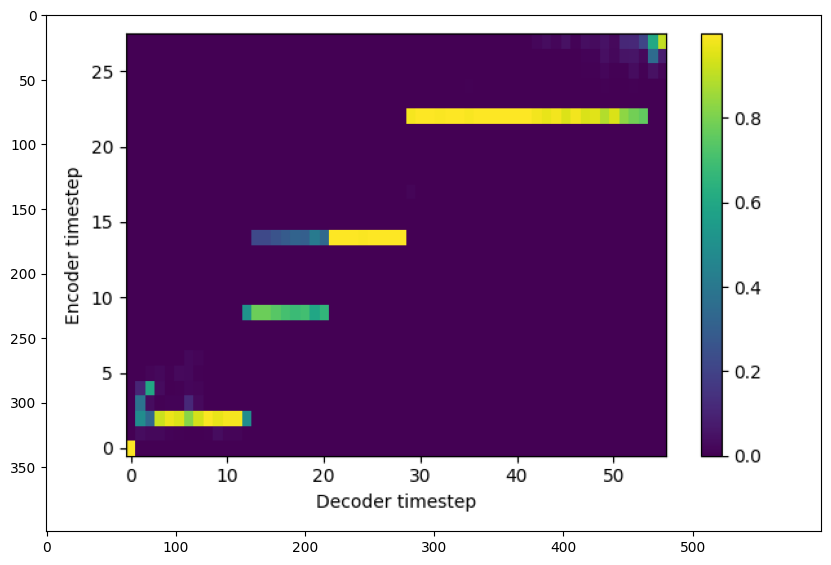

7


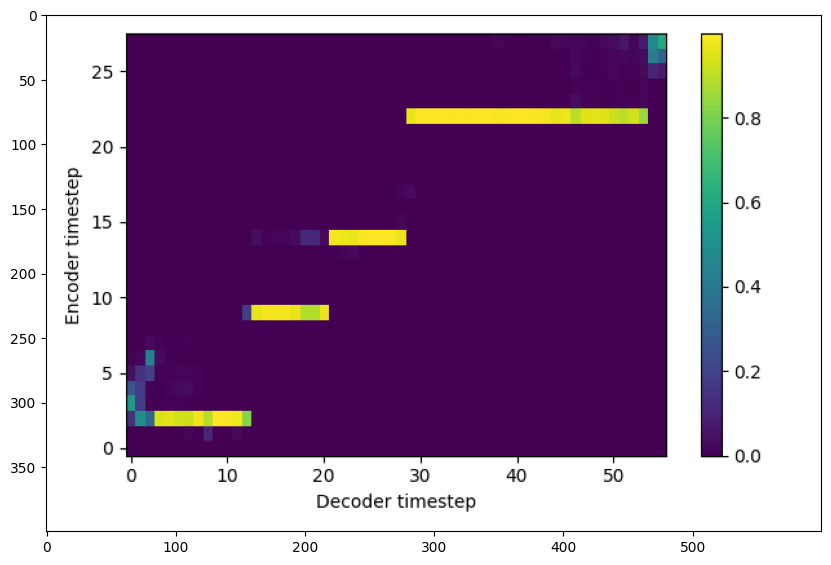

8


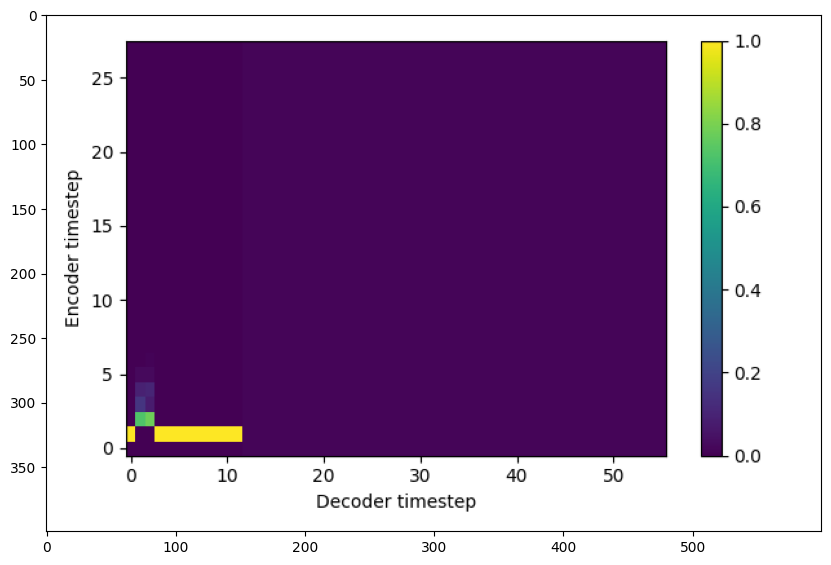

9


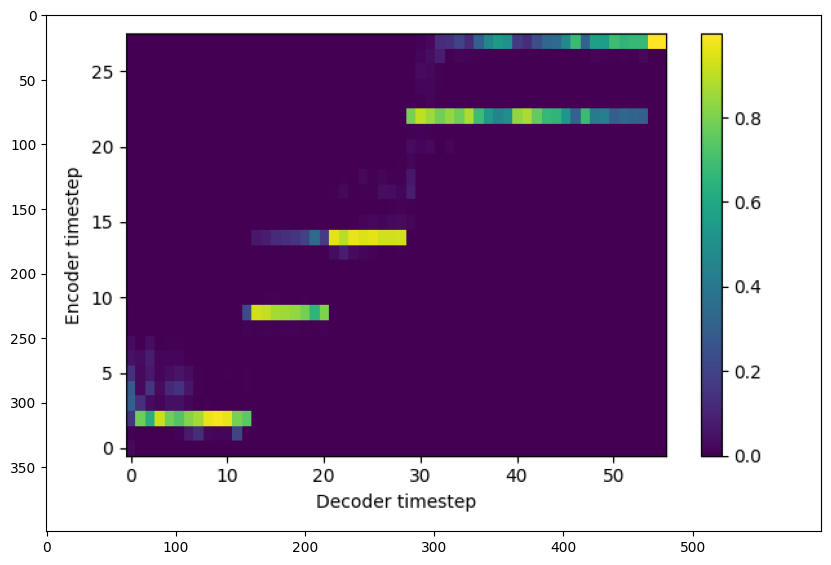

10


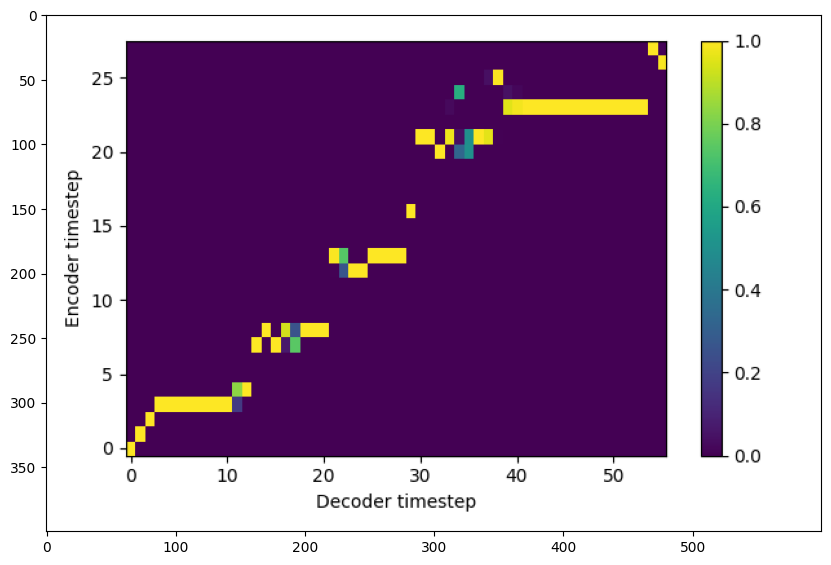

11


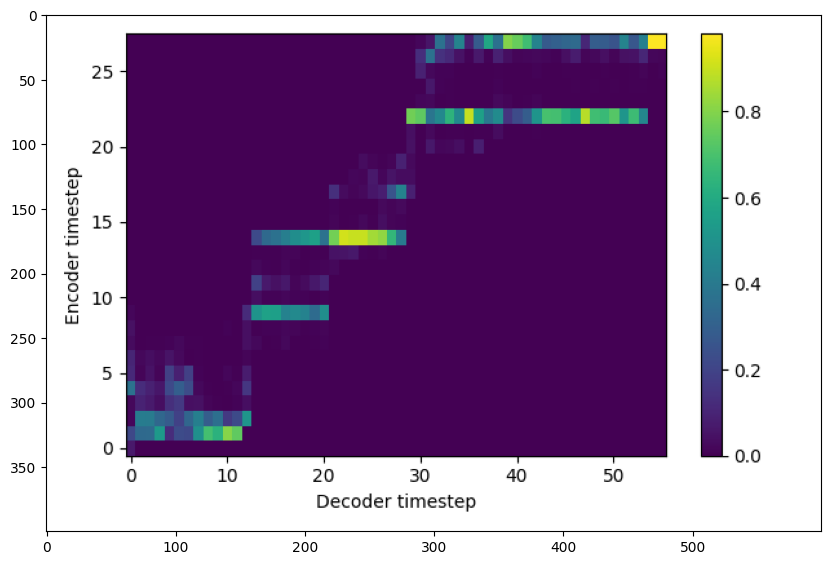

In [30]:
for idx in range(len(headwise_cross_attention_maps[0])):
    cross_attn_map_image = Image.fromarray(headwise_cross_attention_maps[1][idx])
    fig, ax = plt.subplots(1, figsize=(10, 60))
    print(idx)
    ax.imshow(cross_attn_map_image)
    plt.pause(0.1)